This notebook aims to prepare modeling: to prepare indicators, to define the target.

# Intro
A. Data collection process is reflected in Hamoye_Capstone_Electrification_data.ipynb and new_data.ipynb It resulted in building  df_all dataset(2166 rows, 39 columns), including all extracted indicators for SSA countries and regions for 1990-2023.


B. Data Cleaning and processing was performed in dataset.ipynb. It included several steps.

To ensure **accuracy and consistency** and prepare for further analysis:
- data types were corrected,
- units of measurement were standardized for uniformity,
- categorical variable 'income_group' were encoded into numerical 'income_group_num',
- column names were standardized.

**The dataset was split into Regions and SSA subsets**.
**Regions subset** :  For many indicators there were no regional data( when only per country information was given in the source), s 15 columns  with 100% missing values were dropped for regions. The rest of indicators in regional data are available at least for one of the versions of regional splitting (World Bank VS other versions).

In **SSA subset**:
- Similar indicators were compared: 'el_gross_production', 'el_net_production', 'el_generation'; 'el_gross_demand', 'el_demand'. Different sources use different names for the same thing: generation/production.
UNData distinguishes between Gross VS Net Production (the difference between them is Energy industries own use and Losses), while Our World in Data, Ember, World Bank give only one indicator 'electricity generation'.
Electricity demand is defined as electricity production/generation adjusted by imports/exports, and there is demand VS gross demand(related to gross/net production - UNData). All these indicators are highly correlated (correlation coefficient is 1), and values for pairs 'el_generation' - 'el_gross_production' and  'el_gross_demand'- 'el_demand' are very similar, so we decided to put aside the indicators from UNData and to take 'el_generation','el_demand' - indicators from the WB which have correspondent regional data and have values for 2022.
- Outliers were identified: South Africa is an outlier for many indicators, and the only country with high income Seychelles is an outlier too. The outliers reflect the situation of high disbalance in SSA countries characteristics. South Africa and Seychelles are genuine outliers, their values are not errors and can't be dropped or cupped. We need a model robust to outliers.
- Multiple missing values were identified and addressed:
 - missing 'net_imports' values were calculated where both 'el_imports' and 'el_exports' are present ('net_imports' = 'el_imports' - 'el_exports'), remaining NaNs were filled with  '0'.
 - Most of the missing values are before 2000 and in 2023, so to build a solid foundation for our model we took 2000-2022 subset.
 - South Sudan has the largest number of missing values(because it was within Sudan fefore 2011), its data is incomplete and can't be imputed, so we decided to drop rows for South Sudan.
 - South Africa has missing values for all years in 'renewables_other' col. They were replaced with the mean for countries with Upper middle income.
 - The remaining  missing values in 2000-2022 subset were imputed with 4 different methods:forward fill and  backward fill, interpolation, KNNImputer, and Prophet model, plots were built to compare the results. Prophet model turned out to be the best method, while other methods give weird values for leading/trailing NaNs or many in a row NaNs.

 So we went forward with the Regions subset and the SSA 2000-2022 dataset where missing values were imputed with the Prophet model.

 12 less important or highly correlated indicators were excluded: 'el_imports', 'el_exports', 'el_gross_demand', 'el_gross_production', 'el_net_production','electr_inst_capacity_combustible', 'electr_inst_capacity_geoterm',
'electr_inst_capacity_hydro', 'electr_inst_capacity_nuclear','electr_inst_capacity_other', 'electr_inst_capacity_solar','electr_inst_capacity_wind'. Remaining most important indicators are ready for future modeling.



# 0.Indicators

**Indicators used in df_pr dataset explained**: column name - indicator - unit - source - years.
1. 'entity' - country SSA or region of the World. 1990-2023
2. 'year' - year the data was gathered 1990-2023
3. 'income_group' - a country's income group estimation: high/low..., defined at 2021 (World Bank)
4. 'gdp_pc' - GDP per capita values (current USD), World Bank, 1990-2023
5. 'el_access_total' - share of total population with access to electricity (%). Having access to electricity is defined in international statistics as having an electricity source that can provide very basic lighting, and charge a phone or power a radio for 4 hours per day(%), World Bank, 1990-2021
6. 'el_access_urban' - share of urban population with access to electricity(%), World Bank, 1990-2021
7. 'el_access_rural' - of rural population with access to electricity (%), World Bank, 1990-2021
8. 'population' - total population(historical estimates in Our World in Data 'population' and UnData 'total_population' combined with .take_first method) 1990-2022
9. 'pop_no_el_access_total' - Total number of people without access to electricity. Having access to electricity is defined as having an electricity source that can provide very basic lighting, and charge a phone or power a radio for 4 hours per day (Our World in Data from World Bank). 1990-2019
10. 'urban_share' - share of urban population in total population(%)(World Bank 'urban_pop_share' and UnData 'urban_share' combined with .take_first method) 1990 - 2022
11. 'el_generation' - Total electricity generation (Our World in Data, Last updated May 8,2024 terawatt-hours). 1990-2023
12. 'el_demand' - Total electricity generation, adjusted for electricity imports and exports(terawatt-hours, Our World in Data, Last updated May 8, 2024) 1990-2023
13. 'net_imports' - Net electricity imports are calculated as electricity imports minus exports (terawatt-hours, Our World in Data) 1990-2023
14. 'el_generation_pc' - Annual average electricity generation per person, measured in kilowatt-hours. (kWh, Our World in Data, Last updated May 8,2024 t1990-2023
15. 'el_demand_pc' - Annual average electricity generation per person while demand_pc_new is for adjusted electricity generation per person (plus imports)(kilowatt-hours, Ember, Yearly electricity data, Updated on 18 June 2024) 1990 - 2022
16. 'final_energy_consumption -  refers to all fuel and energy that are delivered to users for their energy use.(Kilowatt-hours, million	UNData) - 2022
17. 'fin_support' - International public aid in support of clean and renewable energies to developing countries. It covers financial supportfor all renewables, Bioenergy, Geothermal energy,Hydropower,Marine energy,Multiple renewables, Solar energy, Wind energy (USD million, TRACKING SDG 7,The Energy Progress Report) 2000-2021
18. 'el_from_coal' - Electricity produced from coal (terawatt-hours, Our World in Data) 1990-2023
19. 'el_from_gas' - Electricity produced from gas(terawatt-hours, Our World in Data) 1990-2023
20. 'el_from_nuclear' - Electricity produced from nuclear emergy (terawatt-hours, Our World in Data) 1990-2023
21. 'el_from_hydro'- Electricity produced from hydro energy (terawatt-hours, Our World in Data) 1990-2023
22. 'el_from_solar'- Electricity produced from solar(terawatt-hours, Our World in Data) 1990-2023
23. 'el_from_oil' - Electricity produced from oil(terawatt-hours, Our World in Data) 1990-2023
24. 'el_from_wind' - Electricity produced from wind(terawatt-hours, Our World in Data) 1990-2023
25. 'el_from_bioenergy' - Electricity produced from bioenery (terawatt-hours, Our World in Data) 1990-2023
26. 'renewables_other' - Electricity produced from other renewables excluding bioenergy (terawatt-hours, Our World in Data) 1990-2023
27. 'el_inst_capacity_total' - Electricity - total net installed capacity of electric power plants, main activity & autoproducer (Kilowatts, thousand, UNData) - 2022
28. 'income_group_num' - the same as 'income_group', but numerical


Indicators used earlier in previous datasets but not included in dff_pr:
- el_inst_capacity_combustible - Electricity - total net installed capacity of electric power plants, combustible fuels (Kilowatts, thousand, UNData) - 2022
- 'el_inst_capacity_geoterm' - Electricity - total net installed capacity of electric power plants, geothermal (Kilowatts, thousand, UNData) - 2022,
- 'el_inst_capacity_hydro -'Electricity - total net installed capacity of electric power plants, hydro' (Kilowatts, thousand, UNData) - 2022,
- 'el_inst_capacity_nuclear' - Electricity - total net installed capacity of electric power plants, nuclear'(Kilowatts, thousand, UNData) - 2022,
- 'el_inst_capacity_other' - Electricity generating capacity - From other sources - Total (Kilowatts, thousand, UNData) - 2022
- 'el_inst_capacity_solar' - Electricity - total net installed capacity of electric power plants, solar (Kilowatts, thousand, UNData) - 2022,

- 'el_inst_capacity_wind' - Electricity - total net installed capacity of electric power plants, wind (Kilowatts, thousand, UNData) - 2022
- 'el_gross_demand' - Electricity - Gross demand (terawatt-hours, UNData) - 2022
- 'el_gross_production' - Electricity - gross production (terawatt-hours, UNData) - 2022. This is the total amount of electricity generated by all power plants within before any deductions.
- 'el_net_production' - Electricity - net production (terawatt-hours, UNData) - 2022. This is the amount of electricity that is actually available for use after subtracting the electricity consumed by the power plants themselves (auxiliary consumption). Net Electricity Production=Gross Electricity Production−Auxiliary Consumption
- 'el_imports' -  Electricity - imports: comprise all electricity entering the national territory. (terawatt-hours, UNData) - 1990- 2022
- 'el_exmports' - Electricity - exports:comprise all electricity leaving the national territory (terawatt-hours, UNData) 1990 - 2022


# 1.Load libraries, read the data

In [1]:
%pip install sidetable

In [2]:
pip install scikit-learn

In [3]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno #visulalize nans
import matplotlib.pyplot as plt
import sidetable as stb
import plotly.express as px
from sklearn.impute import KNNImputer
from prophet import Prophet
import missingno as msno #visulalize nans

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
#our initial dataset with all indicators, all entities, all years 1990-2023
dff_all=pd.read_csv('/content/drive/MyDrive/Hamoye_capstone_project_data/df_all.csv')
dff_all.head(2)

,entity,income_group,year,electricity_access_total,electricity_access_urban,electricity_access_rural,gdp_pc,electricity_generation,electricity_pc,electricity_from_coal,...,electr_inst_capacity_other,electr_inst_capacity_solar,electr_inst_capacity_total,electr_inst_capacity_wind,final_energy_consumption,el_gross_demand,el_gross_production,el_net_production,el_imports,el_exports
0,Africa (),NaN,1990,NaN,NaN,NaN,NaN,NaN,499.52590,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Africa (),NaN,1991,NaN,NaN,NaN,NaN,NaN,495.91983,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
#Dataset for regions
dff_reg=pd.read_csv('/content/drive/MyDrive/Hamoye_capstone_project_data/df_reg.csv')
dff_reg.head(2)

,entity,year,gdp_pc,population,urban_share,el_access_total,el_access_urban,el_access_rural,pop_no_el_access_total,el_generation,...,el_from_gas,el_from_nuclear,el_from_hydro,el_from_solar,el_from_oil,el_from_wind,el_from_bioenergy,renewables_other,net_imports,fin_support
0,Africa (),1990,NaN,638157250.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
1,Africa (),1991,NaN,655040500.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN


In [10]:
#dataset for SSA countries
dff_ssa=pd.read_csv('/content/drive/MyDrive/Hamoye_capstone_project_data/df_ssa.csv')
dff_ssa.head(2)

,entity,year,income_group,gdp_pc,population,urban_share,el_access_total,el_access_urban,el_access_rural,pop_no_el_access_total,...,el_inst_capacity_hydro,el_inst_capacity_nuclear,el_inst_capacity_other,el_inst_capacity_solar,el_inst_capacity_total,el_inst_capacity_wind,net_imports,el_imports,el_exports,fin_support
0,Angola,1990,Lower middle income,949.92130,11828643.0,37.144,NaN,NaN,NaN,NaN,...,412.0,0.0,0.0,0.0,462.0,0.0,0.0,NaN,NaN,NaN
1,Angola,1991,Lower middle income,850.55615,12228698.0,38.580,NaN,NaN,NaN,NaN,...,412.0,0.0,0.0,0.0,462.0,0.0,0.0,NaN,NaN,NaN


In [11]:
dff_ssa.columns

Index(['entity', 'year', 'income_group', 'gdp_pc', 'population', 'urban_share',
       'el_access_total', 'el_access_urban', 'el_access_rural',
       'pop_no_el_access_total', 'el_generation', 'el_generation_pc',
       'el_gross_production', 'el_net_production', 'el_demand', 'el_demand_pc',
       'el_gross_demand', 'final_energy_consumption', 'el_from_coal',
       'el_from_gas', 'el_from_nuclear', 'el_from_hydro', 'el_from_solar',
       'el_from_oil', 'el_from_wind', 'el_from_bioenergy', 'renewables_other',
       'el_inst_capacity_combustible', 'el_inst_capacity_geoterm',
       'el_inst_capacity_hydro', 'el_inst_capacity_nuclear',
       'el_inst_capacity_other', 'el_inst_capacity_solar',
       'el_inst_capacity_total', 'el_inst_capacity_wind', 'net_imports',
       'el_imports', 'el_exports', 'fin_support'],
      dtype='object')

In [12]:
#subset of SSA dataset for only 2000-2022
ssa_00_22=pd.read_csv('/content/drive/MyDrive/Hamoye_capstone_project_data/ssa_00_22.csv')
ssa_00_22.head(2)

,entity,year,income_group,gdp_pc,population,urban_share,el_access_total,el_access_urban,el_access_rural,pop_no_el_access_total,...,el_inst_capacity_hydro,el_inst_capacity_nuclear,el_inst_capacity_other,el_inst_capacity_solar,el_inst_capacity_total,el_inst_capacity_wind,net_imports,el_imports,el_exports,fin_support
0,Angola,2000,Lower middle income,556.8842,16394067.0,50.087,24.238865,44.9316,3.473994,NaN,...,390.0,0.0,0.0,0.0,500.0,0.0,0.0,NaN,NaN,0.0
1,Angola,2001,Lower middle income,527.4641,16941584.0,51.274,20.000000,30.0000,9.477077,13556602.0,...,390.0,0.0,0.0,0.0,500.0,0.0,0.0,NaN,NaN,0.0


In [13]:
#subset of indicators for ssa countries 2000-2022
dff=pd.read_csv('/content/drive/MyDrive/Hamoye_capstone_project_data/dff.csv')
dff.head(2)

,entity,year,income_group,gdp_pc,el_access_total,el_access_urban,el_access_rural,population,pop_no_el_access_total,urban_share,...,el_from_coal,el_from_gas,el_from_nuclear,el_from_hydro,el_from_solar,el_from_oil,el_from_wind,el_from_bioenergy,renewables_other,el_inst_capacity_total
0,Angola,2000,Lower middle income,556.8842,24.238865,44.9316,3.473994,16394067.0,NaN,50.087,...,0.0,0.0,0.0,0.91,0.0,0.53,0.0,0.0,0.0,500.0
1,Angola,2001,Lower middle income,527.4641,20.000000,30.0000,9.477077,16941584.0,13556602.0,51.274,...,0.0,0.0,0.0,1.02,0.0,0.62,0.0,0.0,0.0,500.0


In [14]:
dff.columns

Index(['entity', 'year', 'income_group', 'gdp_pc', 'el_access_total',
       'el_access_urban', 'el_access_rural', 'population',
       'pop_no_el_access_total', 'urban_share', 'el_generation',
       'el_generation_adj', 'net_imports', 'el_generation_pc',
       'el_generation_adj_pc', 'final_energy_consumption', 'finans_support',
       'el_from_coal', 'el_from_gas', 'el_from_nuclear', 'el_from_hydro',
       'el_from_solar', 'el_from_oil', 'el_from_wind', 'el_from_bioenergy',
       'renewables_other', 'el_inst_capacity_total'],
      dtype='object')

In [15]:
#the same dataset with missing values imputed with Prophet model
dff_pr=pd.read_csv('/content/drive/MyDrive/Hamoye_capstone_project_data/dff_pr.csv')
dff_pr.head(2)

,entity,year,income_group,gdp_pc,el_access_total,el_access_urban,el_access_rural,population,pop_no_el_access_total,urban_share,...,el_from_coal,el_from_gas,el_from_nuclear,el_from_hydro,el_from_solar,el_from_oil,el_from_wind,el_from_bioenergy,renewables_other,el_inst_capacity_total
0,Angola,2000,Lower middle income,556.884216,24.238865,44.9316,3.473994,16394067.0,1.210024e+07,50.087,...,0.0,0.0,0.0,0.91,0.0,0.53,0.0,0.0,0.0,500.0
1,Angola,2001,Lower middle income,527.464111,20.000000,30.0000,9.477077,16941584.0,1.355660e+07,51.274,...,0.0,0.0,0.0,1.02,0.0,0.62,0.0,0.0,0.0,500.0


In [16]:
dff_pr.columns

Index(['entity', 'year', 'income_group', 'gdp_pc', 'el_access_total',
       'el_access_urban', 'el_access_rural', 'population',
       'pop_no_el_access_total', 'urban_share', 'el_generation', 'el_demand',
       'net_imports', 'el_generation_pc', 'el_demand_pc',
       'final_energy_consumption', 'fin_support', 'el_from_coal',
       'el_from_gas', 'el_from_nuclear', 'el_from_hydro', 'el_from_solar',
       'el_from_oil', 'el_from_wind', 'el_from_bioenergy', 'renewables_other',
       'el_inst_capacity_total'],
      dtype='object')

In [17]:
dff.describe()

,year,gdp_pc,el_access_total,el_access_urban,el_access_rural,population,pop_no_el_access_total,urban_share,el_generation,el_generation_adj,...,el_from_coal,el_from_gas,el_from_nuclear,el_from_hydro,el_from_solar,el_from_oil,el_from_wind,el_from_bioenergy,renewables_other,el_inst_capacity_total
count,1127.000000,1087.000000,1111.000000,1120.000000,981.000000,1.103000e+03,9.620000e+02,1127.000000,1115.000000,1115.000000,...,1115.000000,1115.000000,1127.000000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,1092.000000,1085.000000
mean,2011.000000,2041.498586,39.745455,65.200120,24.829963,1.882036e+07,1.191058e+07,40.582650,8.513839,8.571345,...,4.812744,0.757570,0.253895,1.963839,0.053139,0.498978,0.063982,0.054664,0.053397,1876.925585
std,6.636194,2888.338304,25.989088,23.442847,25.921276,2.922612e+07,1.622486e+07,17.215847,35.070444,34.668111,...,32.245825,3.236448,1.770553,3.432596,0.486237,0.919793,0.588804,0.121625,0.455301,6829.760995
min,2000.000000,110.460880,0.796383,3.500000,0.000000,8.007300e+04,8.460000e+02,8.246000,0.020000,0.020000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
25%,2005.000000,514.876465,16.600000,49.224276,4.903049,2.173026e+06,1.357352e+06,27.928500,0.290000,0.350000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,101.280000
50%,2011.000000,888.781070,36.900000,68.356465,16.780775,1.046729e+07,7.812776e+06,39.325000,1.030000,1.460000,...,0.000000,0.000000,0.000000,0.280000,0.000000,0.160000,0.000000,0.000000,0.000000,330.290000
75%,2017.000000,1985.589450,56.500000,85.000000,33.700000,2.125228e+07,1.339886e+07,51.587000,5.070000,4.760000,...,0.000000,0.000000,0.000000,2.000000,0.010000,0.480000,0.000000,0.050000,0.000000,1207.000000
max,2022.000000,19849.717000,100.000000,100.000000,100.000000,2.167834e+08,8.962977e+07,90.735000,263.490000,260.340000,...,247.580000,28.970000,15.030000,17.090000,10.130000,6.710000,9.700000,0.700000,5.520000,61961.500000


In [18]:
dff_pr.describe()

,year,gdp_pc,el_access_total,el_access_urban,el_access_rural,population,pop_no_el_access_total,urban_share,el_generation,el_demand,...,el_from_coal,el_from_gas,el_from_nuclear,el_from_hydro,el_from_solar,el_from_oil,el_from_wind,el_from_bioenergy,renewables_other,el_inst_capacity_total
count,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1.104000e+03,1.104000e+03,1104.000000,1104.000000,1104.000000,...,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000
mean,2011.000000,2012.554664,39.945800,65.940714,22.479274,1.891110e+07,1.147146e+07,41.047288,8.593324,8.651404,...,4.860697,0.765118,0.259185,1.983406,0.053605,0.498668,0.064620,0.055208,0.052817,1961.544375
std,6.636256,2874.185296,25.950915,22.791172,25.436343,2.934209e+07,1.628030e+07,17.086351,35.235790,34.831218,...,32.402617,3.251657,1.788534,3.444035,0.488633,0.924351,0.591698,0.122107,0.452852,7029.895816
min,2000.000000,110.460876,1.279584,3.500000,0.000000,8.007300e+04,1.442758e+02,8.246000,0.020000,0.020000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
25%,2005.000000,506.835602,16.969542,49.887365,3.274249,2.130476e+06,1.177133e+06,28.441500,0.280000,0.350000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,107.375000
50%,2011.000000,857.107391,37.139817,68.850895,13.772454,1.048111e+07,7.195126e+06,39.783500,1.065000,1.475000,...,0.000000,0.000000,0.000000,0.300000,0.000000,0.160000,0.000000,0.000000,0.000000,363.617508
75%,2017.000000,1941.656311,56.500000,85.147210,31.656669,2.164752e+07,1.303478e+07,51.981750,5.162500,4.827500,...,0.000000,0.000000,0.000000,2.022500,0.010000,0.460000,0.000000,0.050000,0.000000,1343.250000
max,2022.000000,19849.716797,100.000000,100.000000,100.000000,2.167834e+08,9.291402e+07,90.735000,263.490000,260.340000,...,247.580000,28.970000,15.030000,17.090000,10.130000,6.710000,9.700000,0.700000,5.520000,63700.699505


#2.Data overview: histograms

array([[<Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'gdp_pc'}>,
        <Axes: title={'center': 'el_access_total'}>,
        <Axes: title={'center': 'el_access_urban'}>,
        <Axes: title={'center': 'el_access_rural'}>],
       [<Axes: title={'center': 'population'}>,
        <Axes: title={'center': 'pop_no_el_access_total'}>,
        <Axes: title={'center': 'urban_share'}>,
        <Axes: title={'center': 'el_generation'}>,
        <Axes: title={'center': 'el_demand'}>],
       [<Axes: title={'center': 'net_imports'}>,
        <Axes: title={'center': 'el_generation_pc'}>,
        <Axes: title={'center': 'el_demand_pc'}>,
        <Axes: title={'center': 'final_energy_consumption'}>,
        <Axes: title={'center': 'fin_support'}>],
       [<Axes: title={'center': 'el_from_coal'}>,
        <Axes: title={'center': 'el_from_gas'}>,
        <Axes: title={'center': 'el_from_nuclear'}>,
        <Axes: title={'center': 'el_from_hydro'}>,
        <Axes: title={'center'

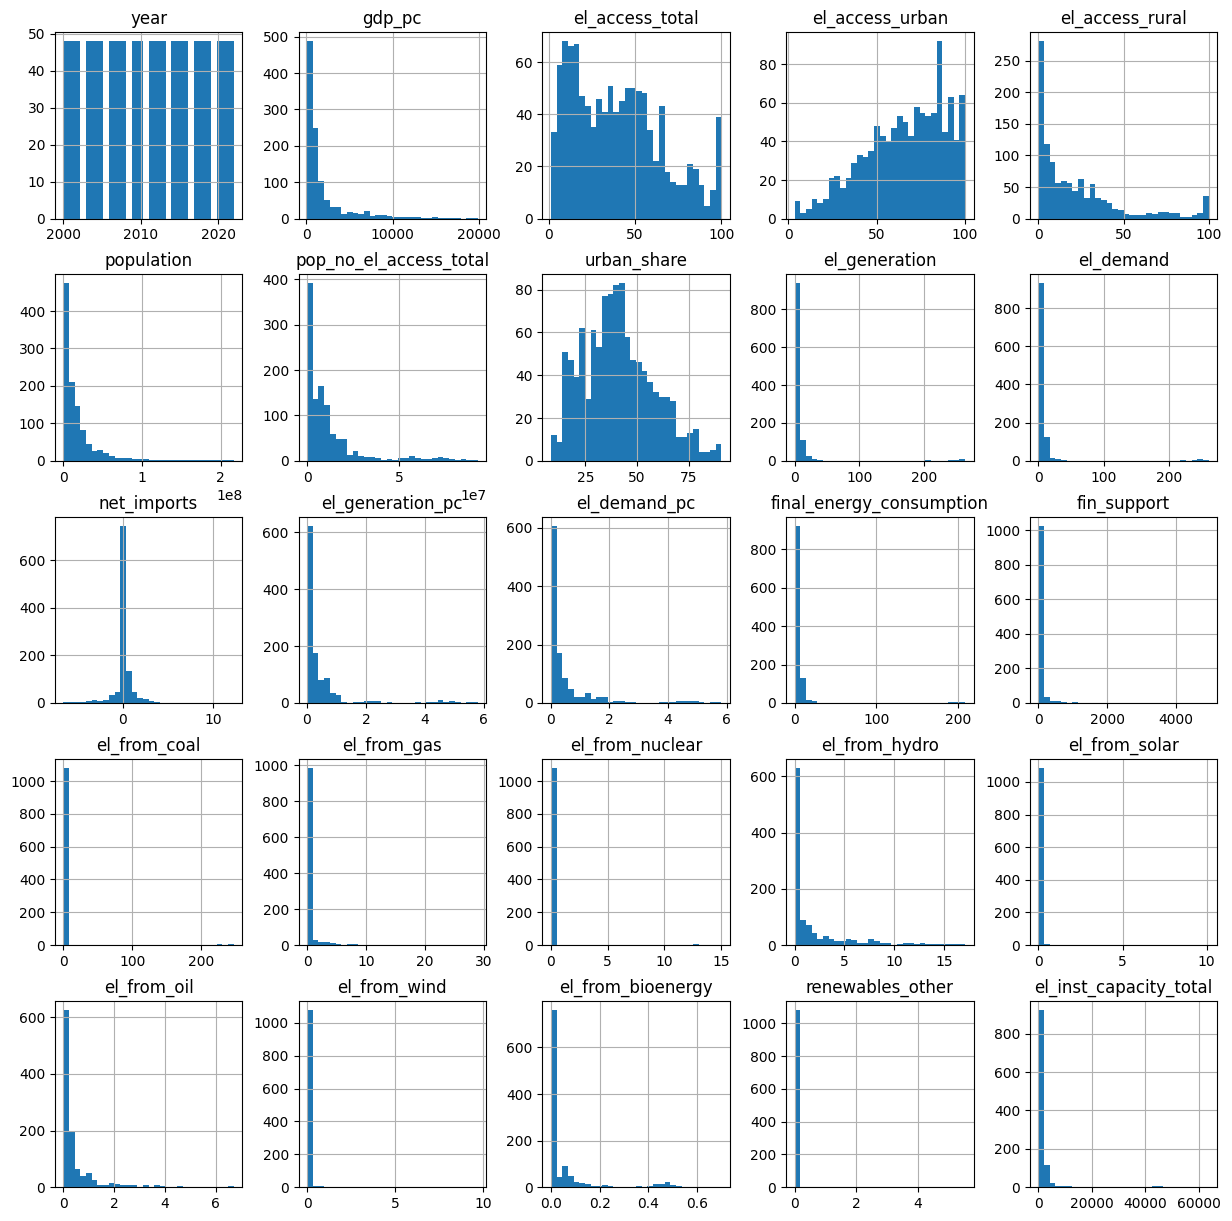

In [19]:
dff_pr.hist(figsize=(15,15), bins= 30)

In [20]:
dff_pr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1104 entries, 0 to 1103
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   entity                    1104 non-null   object 
 1   year                      1104 non-null   int64  
 2   income_group              1104 non-null   object 
 3   gdp_pc                    1104 non-null   float64
 4   el_access_total           1104 non-null   float64
 5   el_access_urban           1104 non-null   float64
 6   el_access_rural           1104 non-null   float64
 7   population                1104 non-null   float64
 8   pop_no_el_access_total    1104 non-null   float64
 9   urban_share               1104 non-null   float64
 10  el_generation             1104 non-null   float64
 11  el_demand                 1104 non-null   float64
 12  net_imports               1104 non-null   float64
 13  el_generation_pc          1104 non-null   float64
 14  el_deman

In [21]:
dff.income_group.value_counts()

income_group
Low income             506
Lower middle income    460
Upper middle income    138
High income             23
Name: count, dtype: int64

In [22]:
# Define mapping dictionary
income_mapping = {
    'Low income': 1,
    'Lower middle income': 2,
    'Upper middle income': 3,
    'High income': 4
}

# Replace income_group with numeric values
dff['income_group_num'] = dff['income_group'].replace(income_mapping)
dff_pr['income_group_num'] = dff_pr['income_group'].replace(income_mapping)

In [23]:
#turn float to integer in population, pop_no_el_access_total  col
dff_pr['population']=dff_pr['population'].astype(int)
dff_pr['pop_no_el_access_total']=dff_pr['pop_no_el_access_total'].astype(int)

#3.New features

The focus of our project is **electricity: demand/supply gap**, that is the difference between what is needed and what people actually get in terms of electricity.

How can we approach the subject having the indicators in our dataset?

Ideally, 100% of people should have access to electricity. But some countries (most of SSA) have much less than 100% access to electricity(electricity_access_total). They use all available electicity - electicity generated from different sources within a country plus imported electicity (that is el_demand) -  and still give access to some share of the population, not to all the population.

Access to electricity is related to supply, but it is measured in percentage. If we know, that X% of population has access to electricity, than the gap will be electricity needed to give access to remaining (100 - X)% of population.
How to measure it?

Traditionally, total number of electricity generated and imported is called electricity demand(total or per capita). The term is misleading, because it is more about supply, not demand - it is total electricity generation, adjusted for electricity imports and exports, delivered(supplied) within a country.
So, we define target demand as electricity needed to give access to 100% of the population.

**APPROACH 1**

If we divide el_demand(terawatt-hours) by electricity_access_total(%) and multiply by 100% - we get ideal number for electricity needed for 100% of population, that is target demand('t_demand'). In most SSA countries the target demand is much greater than 'demand' as indicator, there's a gap between them. This gap represents demand/supply gap.

**SUPPLY** = 'el_demand' (electricity delivered (supplied) in a country, or what do people actually get within a country(generated and imported) - TWh)

**ACCESS** = 'el_access_total' (% of total population with access to electricity - %)

**SUPPLY RATE** = SUPPLY/ ACCESS = 'el_demand' / 'el_access_total' (electricity delivered to 1% of the population with access to electricity - TWh / %)

**TARGET DEMAND1** = 100% * SUPPLY RATE = 100% * 'el_demand'/'el_access_total' ( Electricity needed to give access to 100% of population - TWh)

**GAP1** = TARGET DEMAND - SUPPLY = 100% * el_generation_adj/el_access_total - el_demand ( missing amount of electricity, the difference between what is needed and what is delivered - tWh)

** APPROACH 2**

If we multiply the number of people without access by the average per capita el_demand, we get electricity needed to people who still have no access to electricity - lacking electricity, or GAP2


**SUPPLY** = 'el_demand' (electricity delivered (supplied) in a country, or what do people actually get within a country(generated and imported) - TWh)

**SUPPLY PER CAPITA** = SUPPLY/ 'population' = 'el_demand_pc' (average electricity supplied per person - megaWh)

**POPULATION WITHOUT ACCESS** - 'pop_no_access_total' (number of people without access to electricity)

**GAP2** = POPULATION WITHOUT ACCESS * SUPPLY PER CAPITA = 'pop_no_el_access_total' * 'el_demand_pc'/1000000 - we get terawatt-hour

**TARGET DEMAND2**= Supply + GAP2 = 'el_generation_adj' + GAP2



In good cases Demand = Supply (we put aside the fact that having access in the survey is having electricity at least for 4 hours a day(not 24 hours), so that is the minimum accepted. How this access is realised is yet another problem). For now in SSA electricity generated is much smaller than is needed. Population is growing faster than electricity generation. To reach the target demand and give access to 100% of population electricity generation and/or import should be increased.

Let's calculate new features.



In [24]:
#supply rate
dff_pr['supply_rate']=dff_pr['el_demand']/dff_pr['el_access_total']
#t_demand1
dff_pr['t_demand1']=100*dff_pr['supply_rate']
#gap1
dff_pr['gap1']=dff_pr['t_demand1']-dff_pr['el_demand']
#gap2
dff_pr['gap2']=dff_pr['pop_no_el_access_total']*dff_pr['el_demand_pc']/1000000
#t_demand2
dff_pr['t_demand2']=dff_pr['el_demand']+dff_pr['gap2']
dff_pr.head()

,entity,year,income_group,gdp_pc,el_access_total,el_access_urban,el_access_rural,population,pop_no_el_access_total,urban_share,...,el_from_wind,el_from_bioenergy,renewables_other,el_inst_capacity_total,income_group_num,supply_rate,t_demand1,gap1,gap2,t_demand2
0,Angola,2000,Lower middle income,556.884216,24.238865,44.931600,3.473994,16394067,12100243,50.087,...,0.0,0.0,0.0,500.0,2,0.059409,5.940872,4.500872,1.089022,2.529022
1,Angola,2001,Lower middle income,527.464111,20.000000,30.000000,9.477077,16941584,13556602,51.274,...,0.0,0.0,0.0,500.0,2,0.082000,8.200000,6.560000,1.355660,2.995660
2,Angola,2002,Lower middle income,872.657654,26.320255,47.670353,2.759651,17516140,12897117,52.461,...,0.0,0.0,0.0,500.0,2,0.066869,6.686865,4.926865,1.289712,3.049712
3,Angola,2003,Lower middle income,982.805603,27.355137,49.043540,2.255916,18124346,13144298,53.645,...,0.0,0.0,0.0,500.0,2,0.072747,7.274685,5.284685,1.445873,3.435873
4,Angola,2004,Lower middle income,1254.696167,28.395485,50.428510,1.653744,18771128,13405173,54.827,...,0.0,0.0,0.0,624.0,2,0.078886,7.888578,5.648578,1.608621,3.848621


G = (100* S/Access)  -  S

G = (100* S - S * Access)/Access

G = S(100-Access)/Access

G = S*(% of pop without access)/Access

G = S*(pop_no_access/population)/(pop_with_access/population)

G = S*pop_no_access/pop_with_access !

In [25]:
def plot_indicators_for_country(dff, country, indicators):
    """
    Plot specified indicators for a given country over the years.

    Parameters:
    - dff (DataFrame): The DataFrame containing the data.
    - country (str): The name of the country to plot the indicators for.
    - indicators (list): List of column names (indicators) to plot.

    Returns:
    - None: The function will display the plots.
    """
    # Filter the DataFrame for the given country
    country_data = dff[dff['entity'] == country]

    # Check if the country exists in the DataFrame
    if country_data.empty:
        print(f"No data available for {country}.")
        return

    # Plot each indicator
    plt.figure(figsize=(14, 10))

    for i, indicator in enumerate(indicators, 1):
        plt.subplot(len(indicators), 1, i)
        plt.plot(country_data['year'], country_data[indicator], marker='o')
        plt.title(f'{indicator} for {country} over Years')
        plt.xlabel('Year')
        plt.ylabel(indicator)
        plt.grid(True)

    plt.tight_layout()
    plt.show()

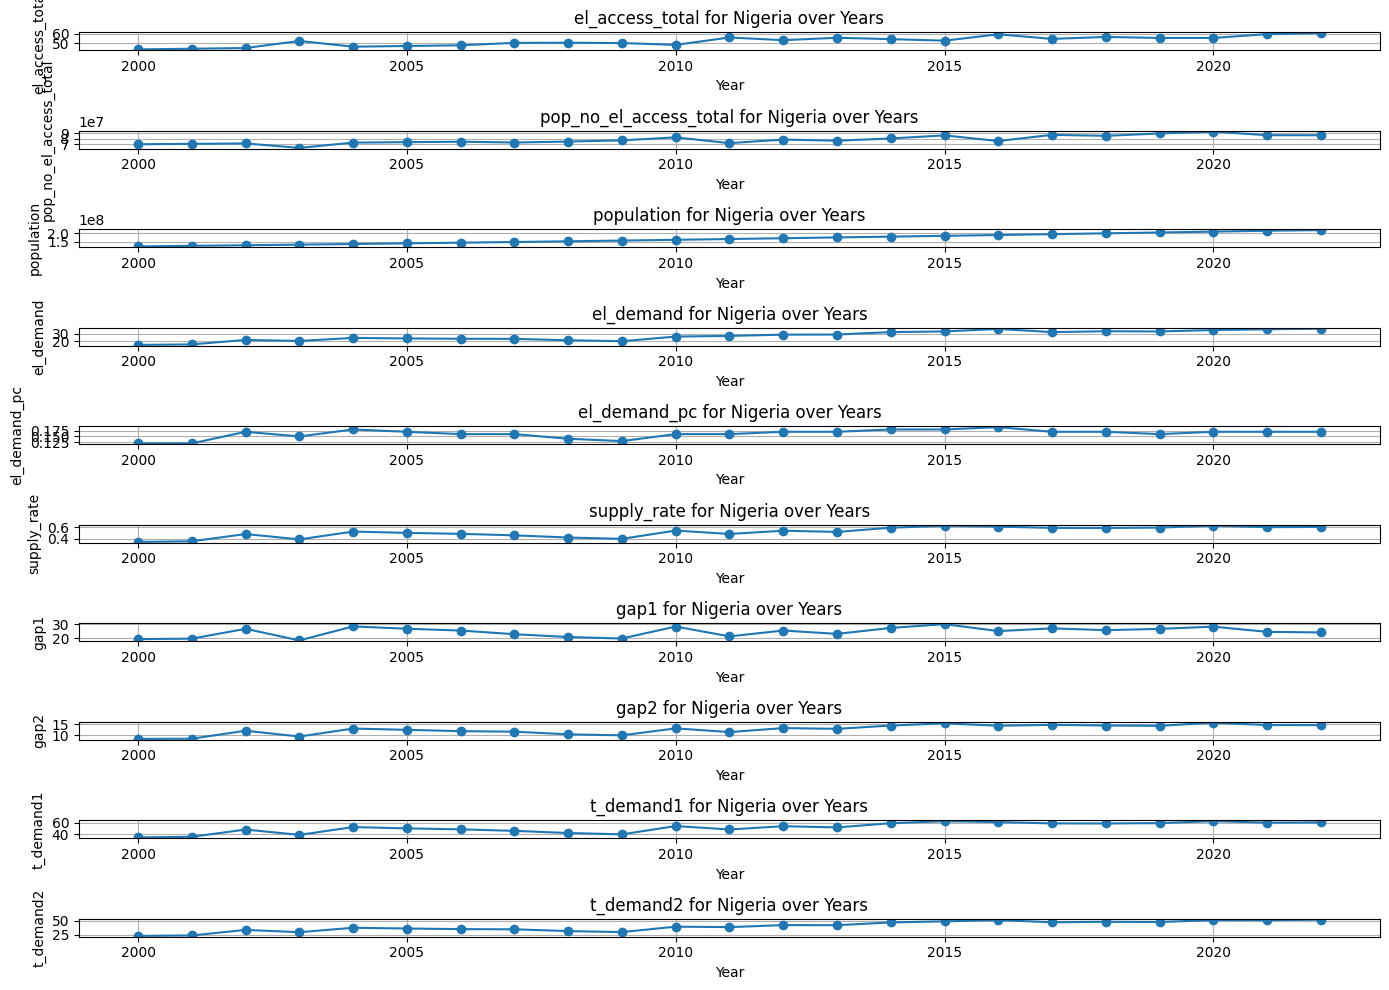

In [26]:
indicators = ['el_access_total', 'pop_no_el_access_total','population', 'el_demand','el_demand_pc','supply_rate','gap1', 'gap2','t_demand1', 't_demand2']

plot_indicators_for_country(dff_pr, 'Nigeria', indicators)


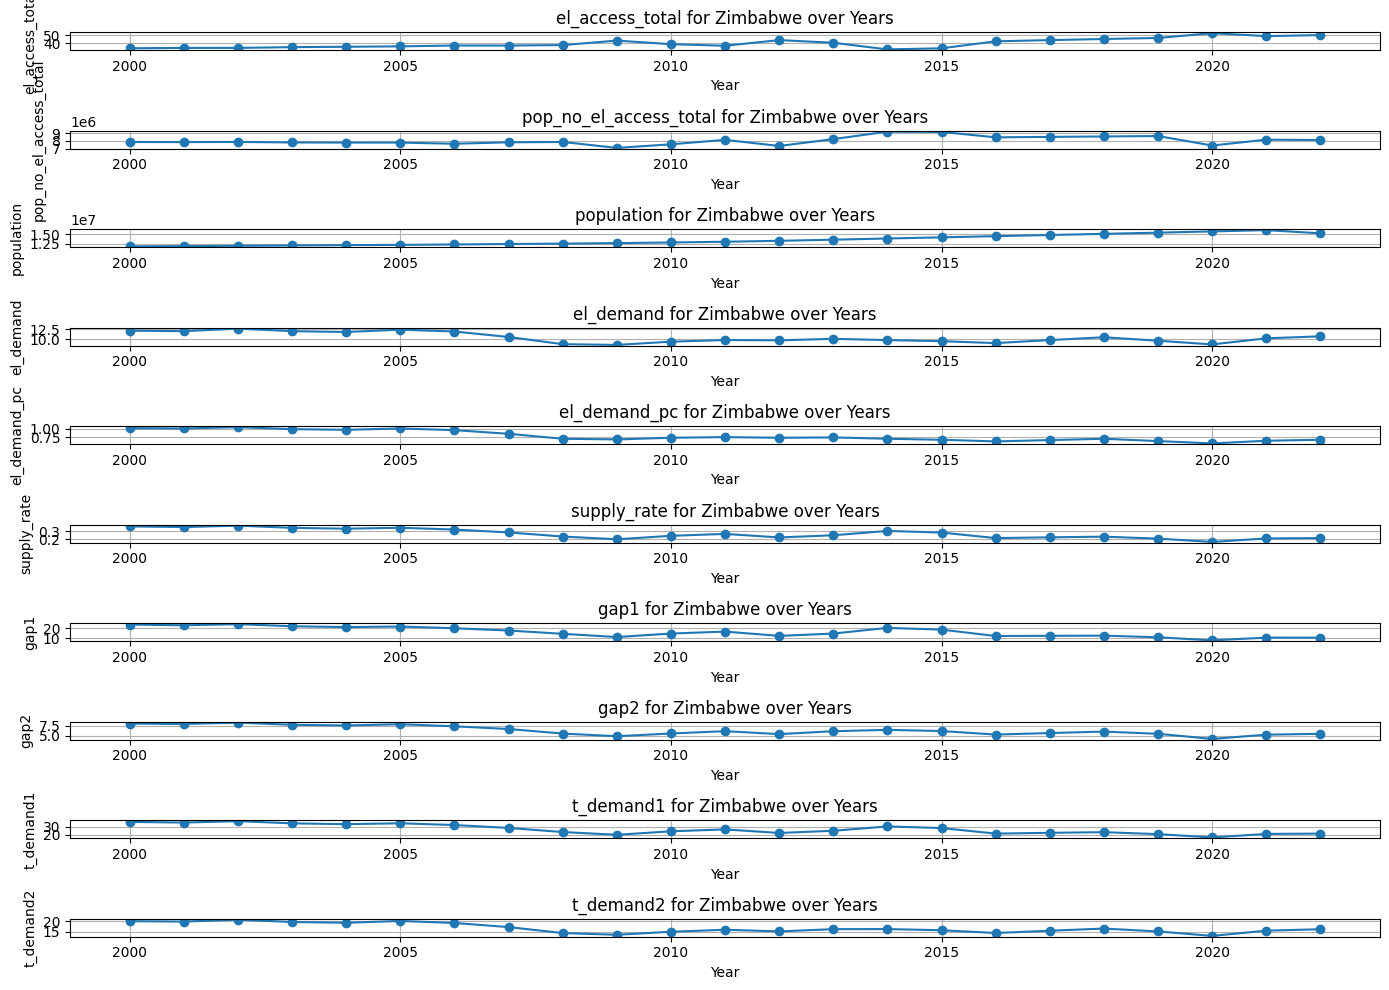

In [27]:
plot_indicators_for_country(dff_pr, 'Zimbabwe', indicators)

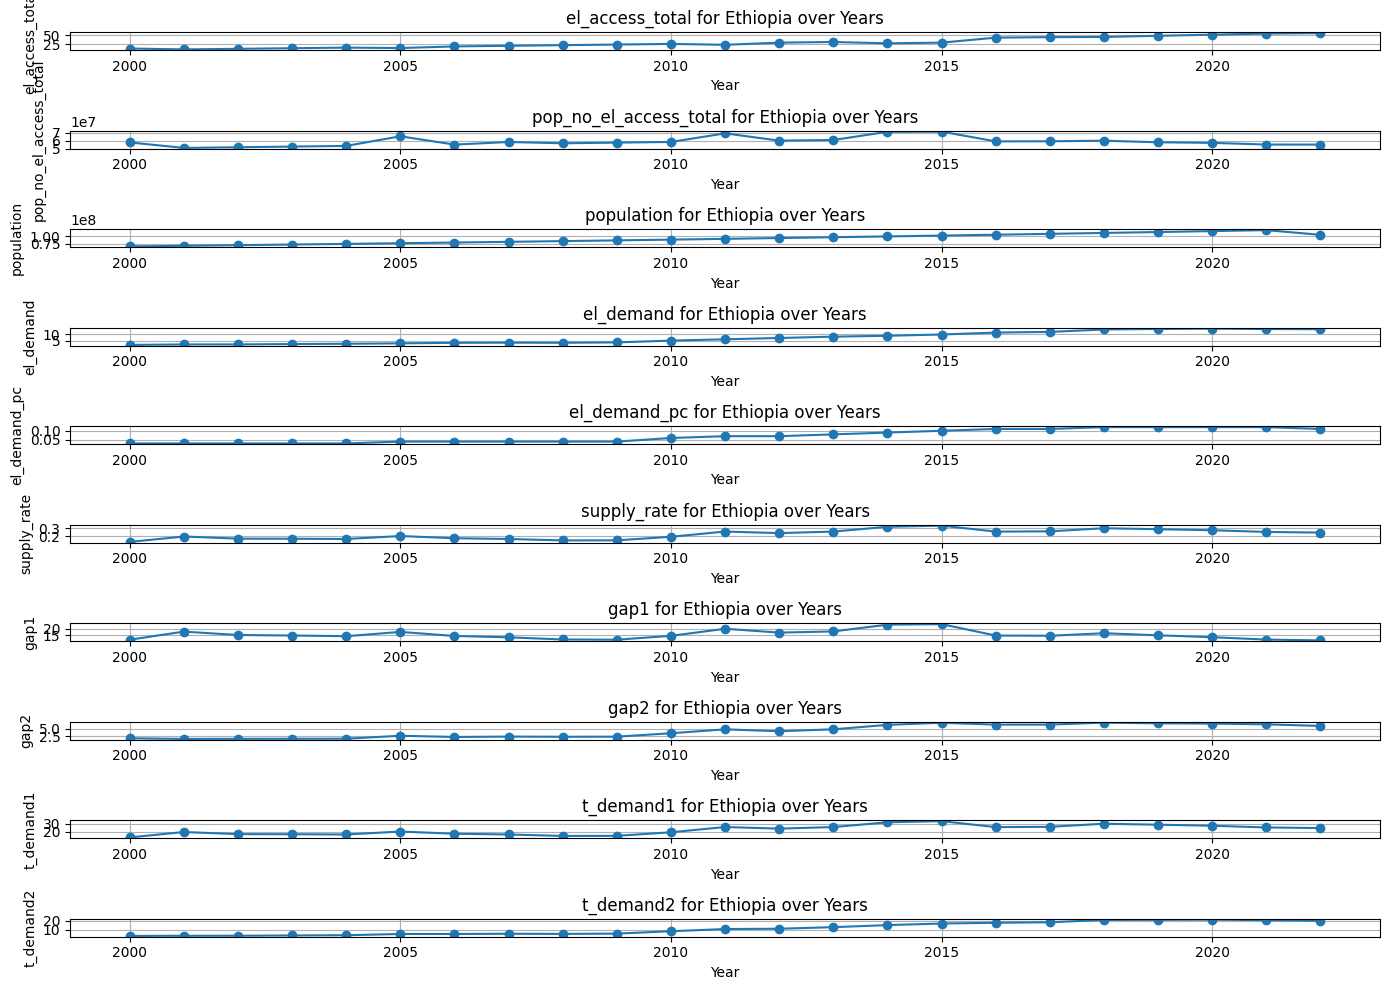

In [28]:
plot_indicators_for_country(dff_pr, 'Ethiopia', indicators)

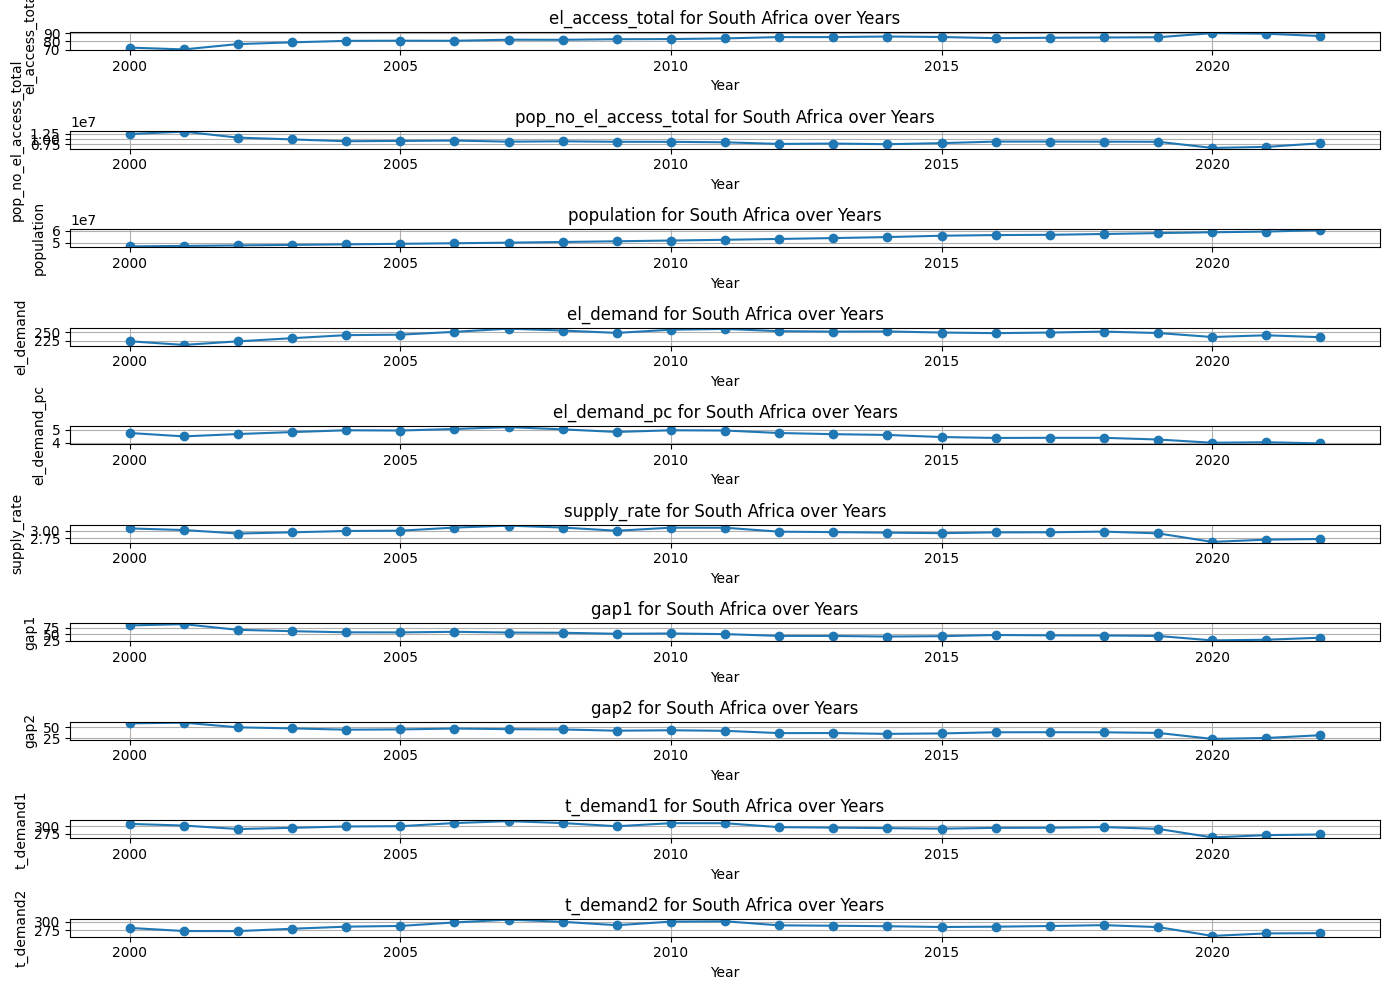

In [29]:
plot_indicators_for_country(dff_pr, 'South Africa', indicators)

#4.Indicators' correlation

In [30]:
dff_pr.corr(numeric_only=True)

,year,gdp_pc,el_access_total,el_access_urban,el_access_rural,population,pop_no_el_access_total,urban_share,el_generation,el_demand,...,el_from_wind,el_from_bioenergy,renewables_other,el_inst_capacity_total,income_group_num,supply_rate,t_demand1,gap1,gap2,t_demand2
year,1.000000e+00,0.154675,0.332453,0.377741,0.240203,0.112999,0.040007,0.185253,0.035111,0.035542,...,0.131763,0.042370,0.081453,0.061347,-3.475706e-15,-0.005234,-0.005234,-0.100888,0.030417,0.035104
gdp_pc,1.546753e-01,1.000000,0.674468,0.498030,0.568091,-0.126310,-0.238621,0.491061,0.200432,0.203179,...,0.127897,0.213164,-0.017481,0.194743,7.791819e-01,0.126240,0.126240,-0.105631,0.111064,0.190717
el_access_total,3.324532e-01,0.674468,1.000000,0.847618,0.872271,-0.035080,-0.245609,0.633700,0.255035,0.257228,...,0.167880,0.290175,0.058550,0.260540,7.277722e-01,0.140799,0.140799,-0.191118,0.177349,0.247273
el_access_urban,3.777407e-01,0.498030,0.847618,1.000000,0.650789,0.115373,-0.054405,0.372822,0.167532,0.170699,...,0.108061,0.234765,0.079649,0.182932,5.712251e-01,0.078467,0.078467,-0.171986,0.161604,0.171051
el_access_rural,2.402033e-01,0.568091,0.872271,0.650789,1.000000,-0.033490,-0.218133,0.338478,0.314264,0.314930,...,0.231768,0.420241,0.093670,0.314662,5.955765e-01,0.208114,0.208114,-0.126198,0.202055,0.300353
population,1.129992e-01,-0.126310,-0.035080,0.115373,-0.033490,1.000000,0.928817,-0.133643,0.288850,0.286731,...,0.151314,0.151038,0.112301,0.366160,-1.052245e-01,0.388567,0.388567,0.485712,0.473993,0.319415
pop_no_el_access_total,4.000664e-02,-0.238621,-0.245609,-0.054405,-0.218133,0.928817,1.000000,-0.284859,0.081136,0.078405,...,0.011867,0.071411,0.073235,0.147691,-2.580129e-01,0.237168,0.237168,0.527763,0.302509,0.114738
urban_share,1.852526e-01,0.491061,0.633700,0.372822,0.338478,-0.133643,-0.284859,1.000000,0.186496,0.188092,...,0.106744,-0.095584,-0.102379,0.189386,5.504732e-01,0.108832,0.108832,-0.122022,0.122950,0.179746
el_generation,3.511100e-02,0.200432,0.255035,0.167532,0.314264,0.288850,0.081136,0.186496,1.000000,0.999602,...,0.557548,0.445455,0.004579,0.984010,2.454585e-01,0.959025,0.959025,0.499842,0.920243,0.997528
el_demand,3.554232e-02,0.203179,0.257228,0.170699,0.314930,0.286731,0.078405,0.188092,0.999602,1.000000,...,0.553253,0.446818,0.004829,0.983331,2.517889e-01,0.957602,0.957602,0.494597,0.921780,0.998111


In [31]:
dff_pr.shape

(1104, 33)

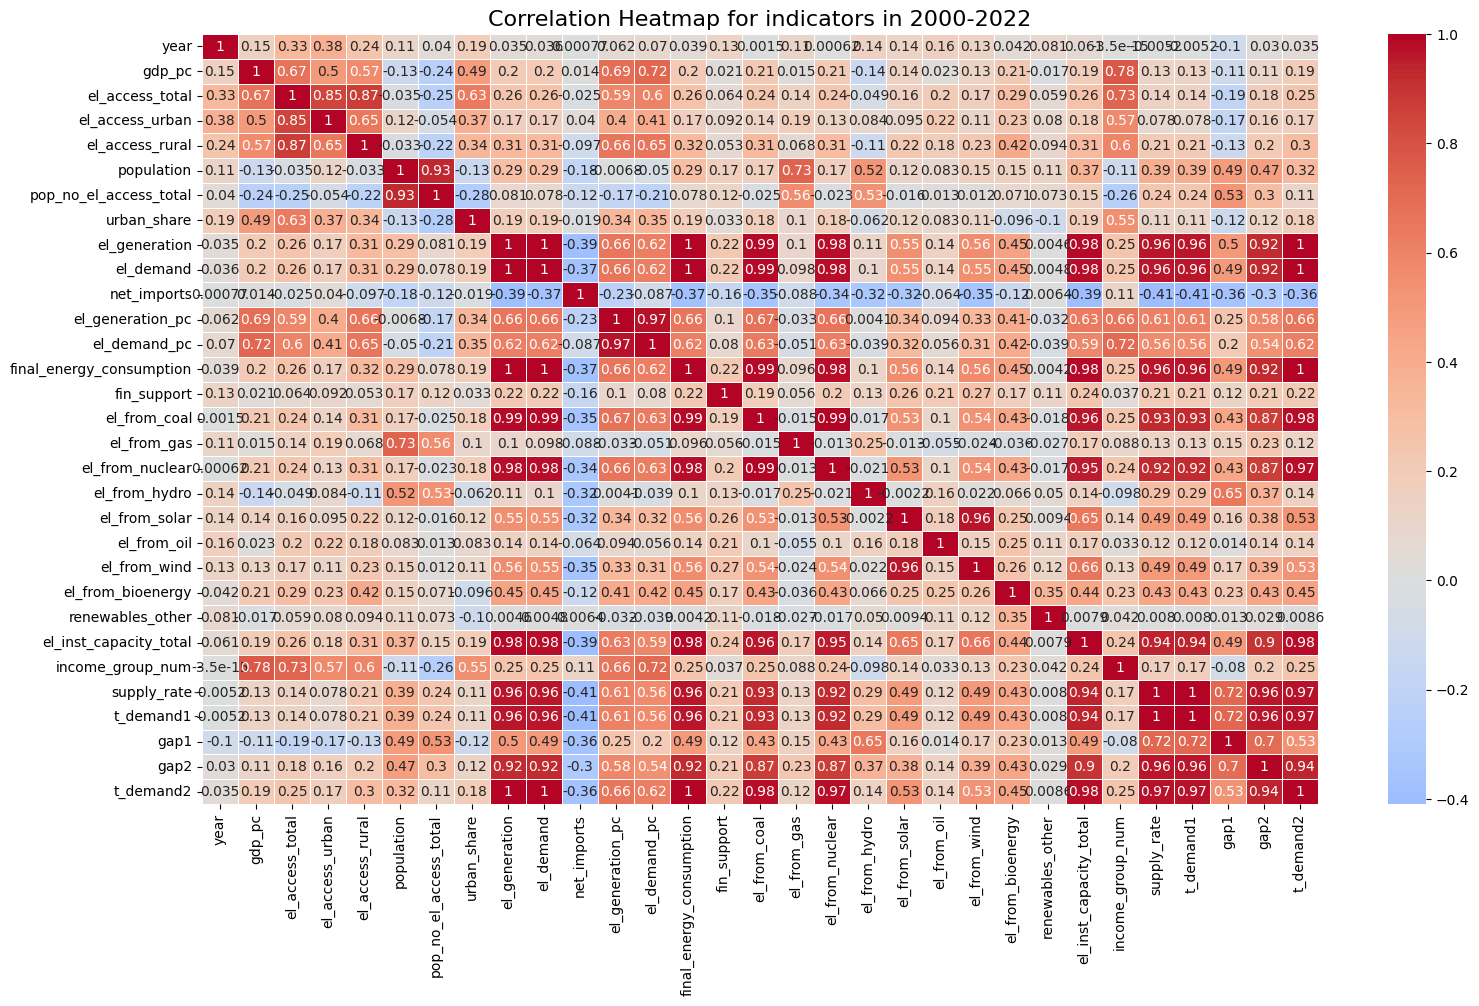

In [32]:
# Create the heatmap
plt.figure(figsize=(18, 10))
sns.heatmap(dff_pr.corr(numeric_only=True), annot=True, cmap='coolwarm', center=0, linewidths=0.5, linecolor='white')

# Display the plot
plt.title('Correlation Heatmap for indicators in 2000-2022', fontsize=16)
plt.show()

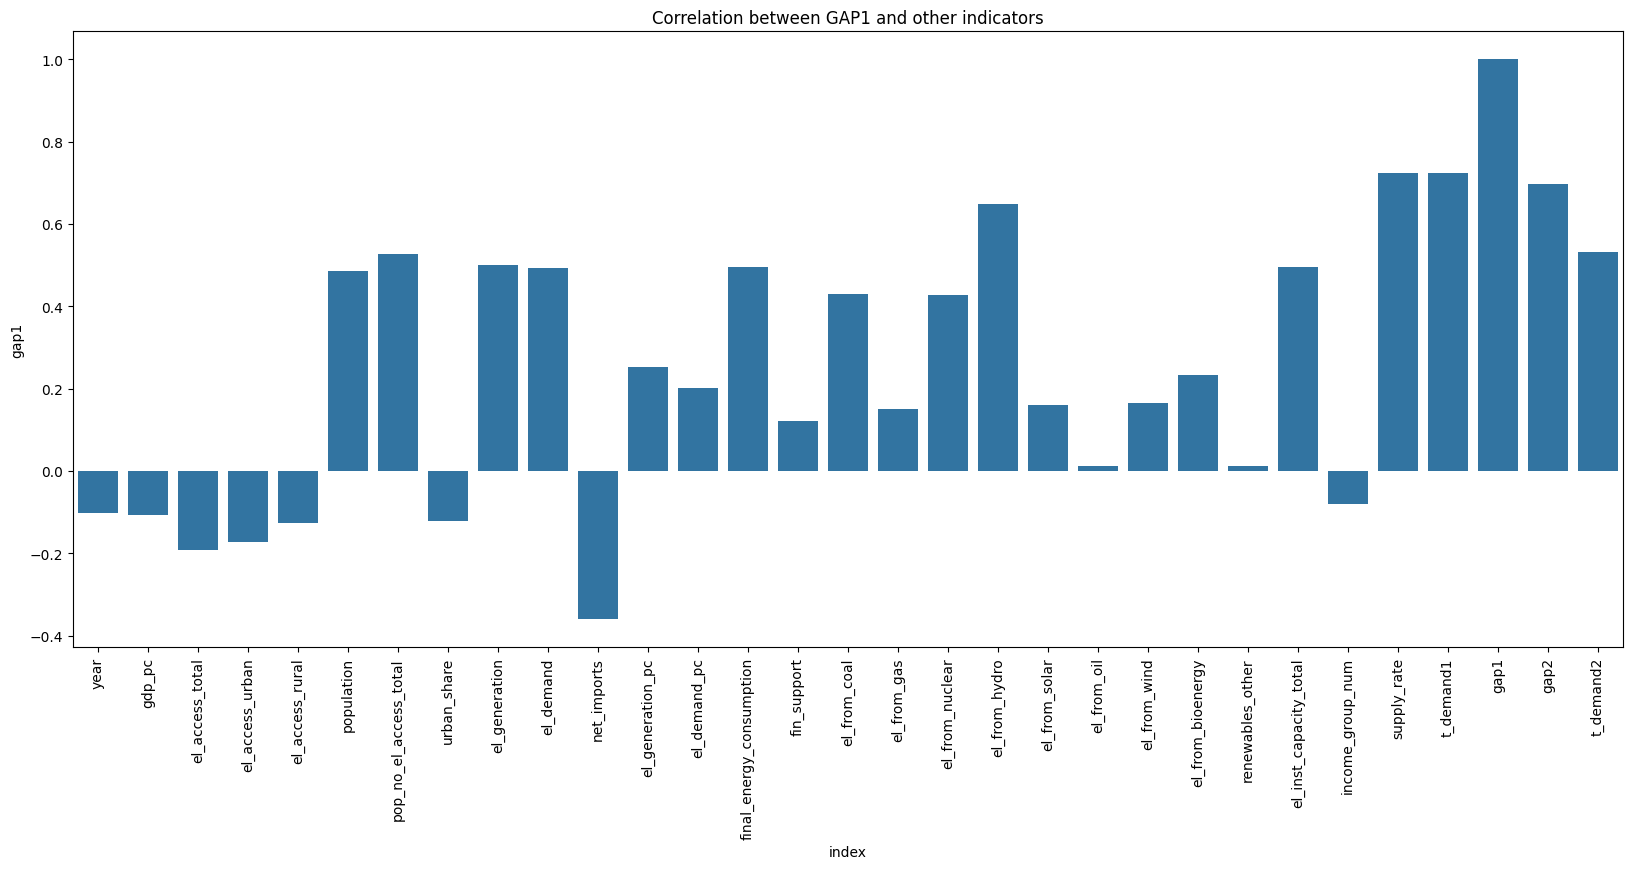

In [33]:
#correlation between GAP1 and other indicators
data = dff_pr.corr(numeric_only=True)['gap1'].reset_index()
plt.figure(figsize=(20, 8))
sns.barplot(x='index', y='gap1', data=data)
plt.xticks(rotation=90)
plt.title('Correlation between GAP1 and other indicators')
plt.show()

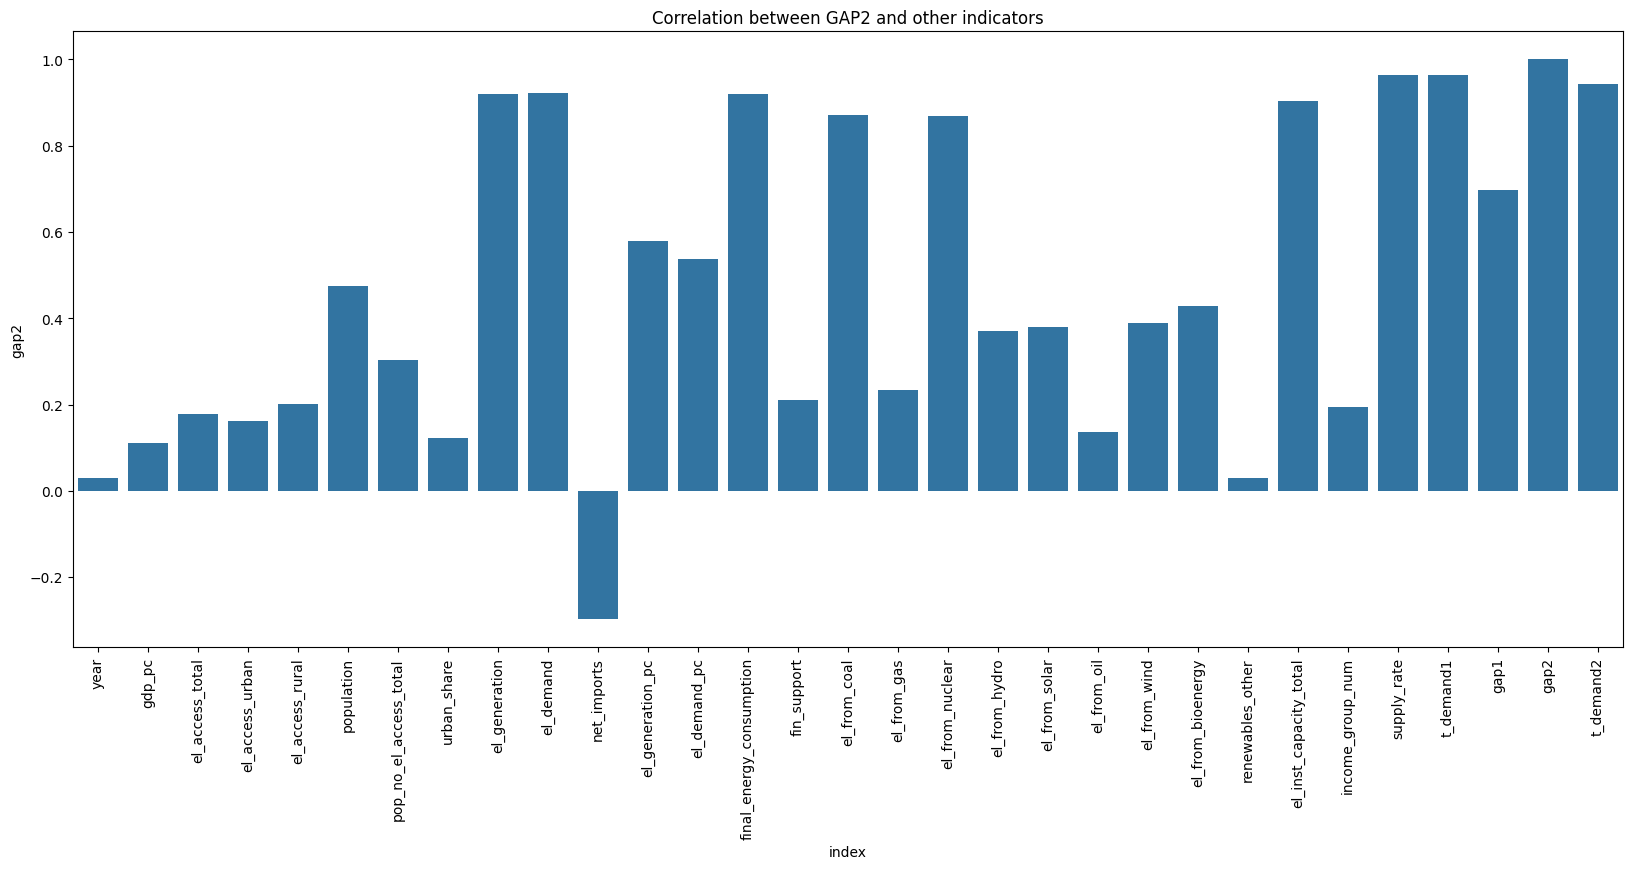

In [34]:
#correlation between GAP2 and other indicators
data = dff_pr.corr(numeric_only=True)['gap2'].reset_index()
plt.figure(figsize=(20, 8))
sns.barplot(x='index', y='gap2', data=data)
plt.xticks(rotation=90)
plt.title('Correlation between GAP2 and other indicators')
plt.show()

#5.Plotting

Compare the features:  group by entity, find the mean value for groups of indicators

In [35]:
#group per entity, find avg 'el_generation_adj','final_energy_consumption', 'demand1','demand2'
avg1=dff_pr.groupby(['entity'])[['el_demand', 't_demand1', 'gap1']].mean().reset_index()
avg1

,entity,el_demand,t_demand1,gap1
0,Angola,7.589565,18.968248,11.378682
1,Benin,1.103913,3.267214,2.163301
2,Botswana,3.464783,7.026118,3.561336
3,Burkina Faso,1.192174,7.903652,6.711478
4,Burundi,0.265652,4.425989,4.160337
5,Cabo Verde,0.333043,0.414037,0.080994
6,Cameroon,6.182174,11.128846,4.946672
7,Central African Republic,0.150435,1.545767,1.395332
8,Chad,0.218696,2.983126,2.764430
9,Comoros,0.065652,0.095779,0.030126


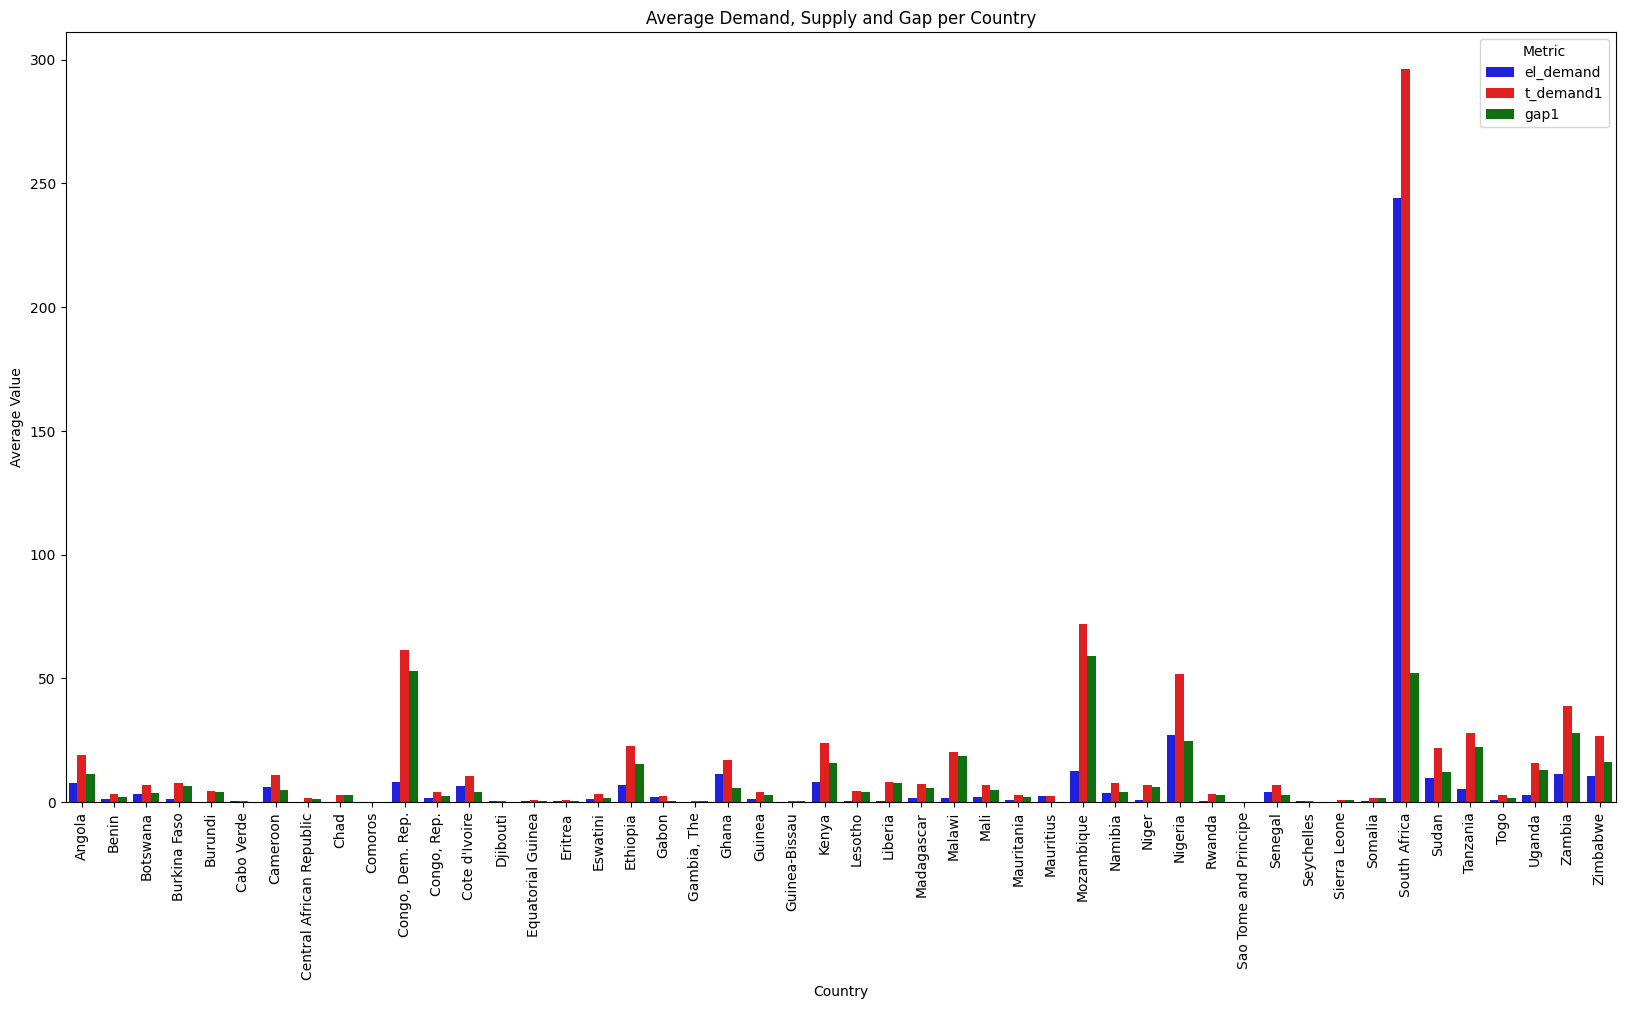

In [36]:
# Melt the DataFrame to long format
avg1_long = avg1.melt(id_vars=['entity'], value_vars=['el_demand', 't_demand1', 'gap1'],
                            var_name='Variable', value_name='Value')
# Plotting
plt.figure(figsize=(20,10))
sns.barplot(x='entity', y='Value', hue='Variable', data=avg1_long, palette=['blue','red','green'])
plt.title('Average Demand, Supply and Gap per Country')
plt.xlabel('Country')
plt.ylabel('Average Value')
plt.legend(title='Metric')
plt.xticks(rotation=90)
plt.show()

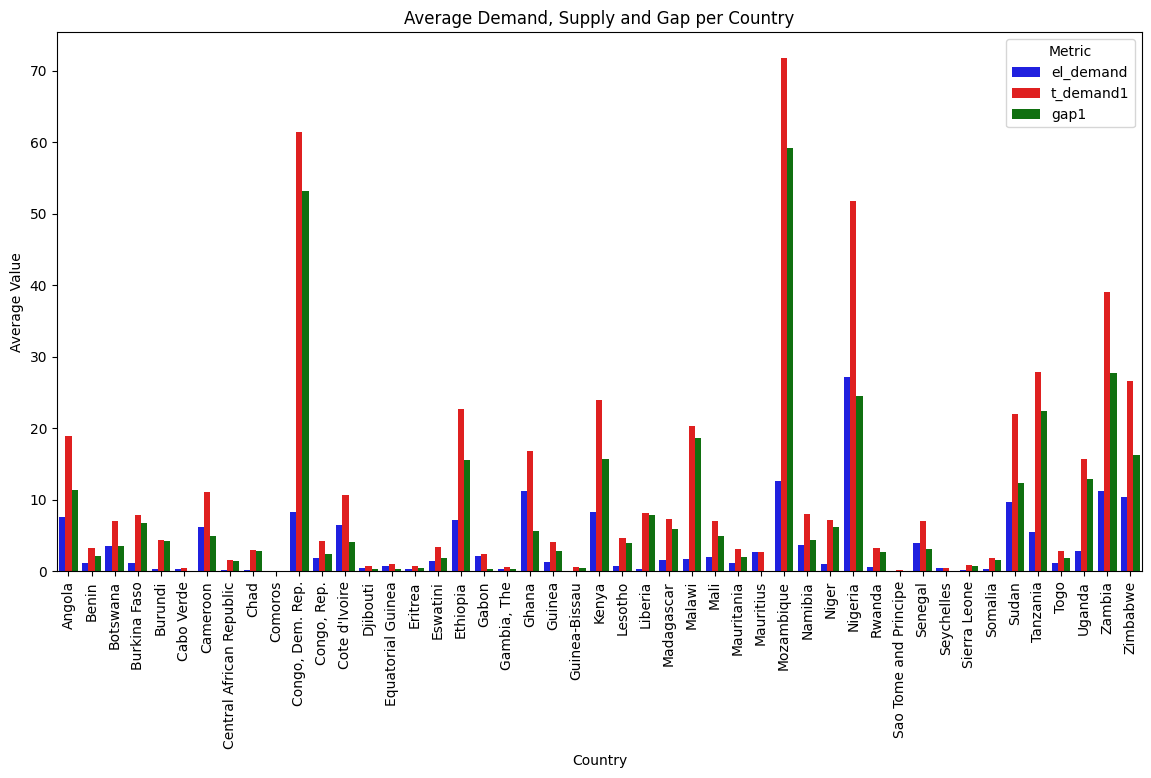

In [37]:
# Exclude South Africa to 'zoom' other countries
dff_pr_filtered = dff_pr[dff_pr['entity'] != 'South Africa']

# Compute the average values per entity
avg1_ = dff_pr_filtered.groupby(['entity'])[['el_demand',  't_demand1', 'gap1']].mean().reset_index()

# Melt the DataFrame to long format
avg1__long = avg1_.melt(id_vars=['entity'], value_vars=['el_demand',  't_demand1', 'gap1'],
                            var_name='Variable', value_name='Value')

# Plotting
plt.figure(figsize=(14, 7))
sns.barplot(x='entity', y='Value', hue='Variable', data=avg1__long, palette=['blue','red','green'])
plt.title('Average Demand, Supply and Gap per Country')
plt.xlabel('Country')
plt.ylabel('Average Value')
plt.legend(title='Metric')
plt.xticks(rotation=90)
plt.show()

In [38]:
dff_pr.columns

Index(['entity', 'year', 'income_group', 'gdp_pc', 'el_access_total',
       'el_access_urban', 'el_access_rural', 'population',
       'pop_no_el_access_total', 'urban_share', 'el_generation', 'el_demand',
       'net_imports', 'el_generation_pc', 'el_demand_pc',
       'final_energy_consumption', 'fin_support', 'el_from_coal',
       'el_from_gas', 'el_from_nuclear', 'el_from_hydro', 'el_from_solar',
       'el_from_oil', 'el_from_wind', 'el_from_bioenergy', 'renewables_other',
       'el_inst_capacity_total', 'income_group_num', 'supply_rate',
       't_demand1', 'gap1', 'gap2', 't_demand2'],
      dtype='object')

In [39]:
#Find the mean for
avg2=dff_pr.groupby(['entity'])[['el_access_total', 'el_access_urban','el_access_rural','urban_share']].mean().reset_index()
avg2

,entity,el_access_total,el_access_urban,el_access_rural,urban_share
0,Angola,36.287721,61.817782,3.435624,60.117435
1,Benin,32.830161,58.253904,13.270604,43.687522
2,Botswana,51.581164,67.772222,22.186967,62.785783
3,Burkina Faso,14.185589,53.332543,2.158627,25.096739
4,Burundi,6.207557,53.954720,1.072393,11.067304
5,Cabo Verde,78.518772,89.055255,63.386398,61.485565
6,Cameroon,54.362895,86.451165,18.778637,52.156043
7,Central African Republic,10.545252,24.417323,1.489891,39.601565
8,Chad,7.186770,24.582840,2.320762,22.365348
9,Comoros,65.475578,83.747741,58.151922,28.388087


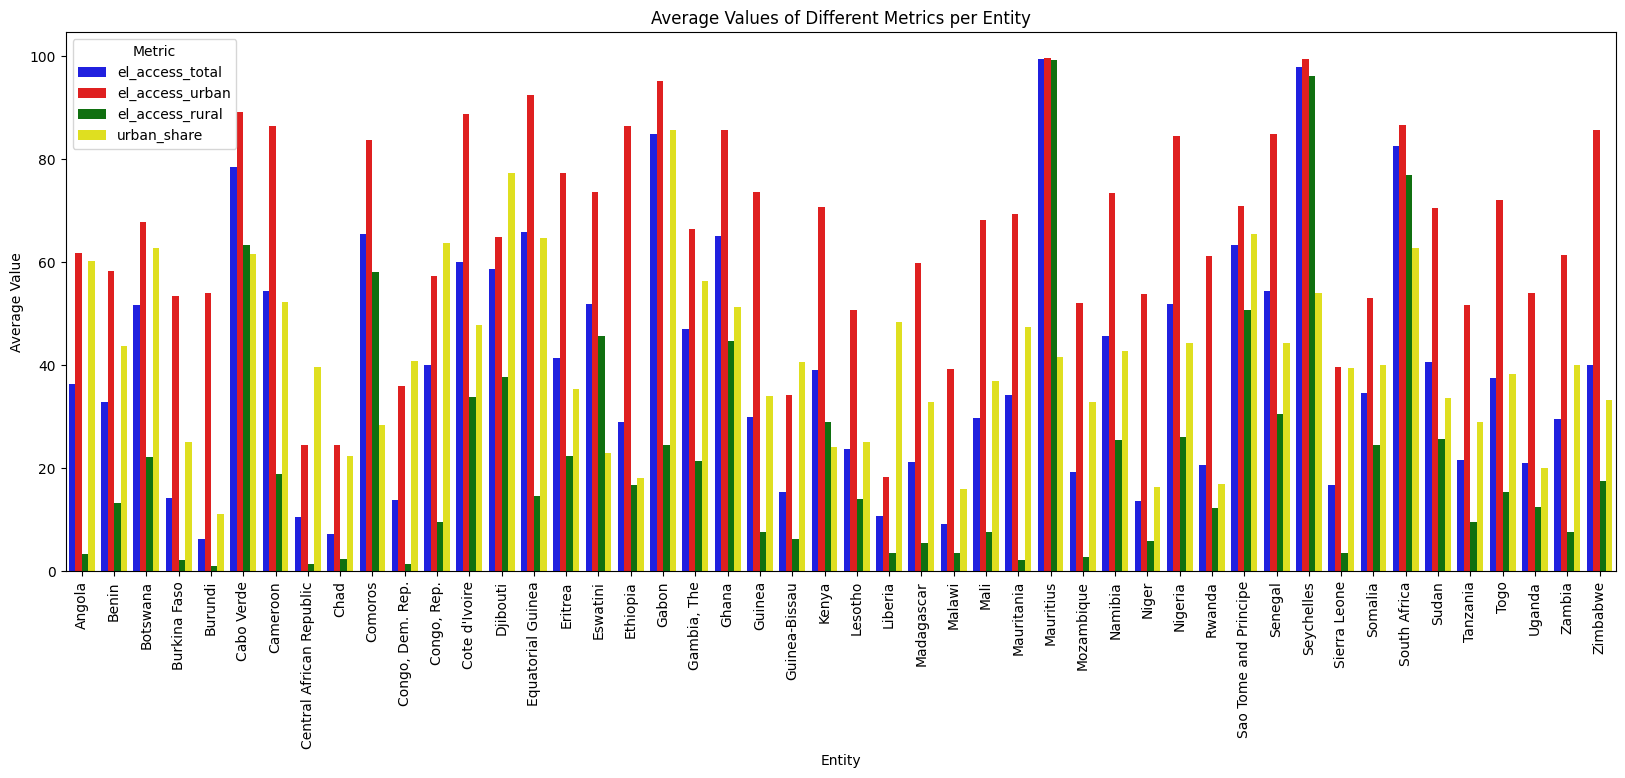

In [40]:
# Melt the DataFrame to long format
avg2_long = avg2.melt(id_vars=['entity'], value_vars=['el_access_total', 'el_access_urban','el_access_rural','urban_share'],
                            var_name='Variable', value_name='Value')
# Plotting
plt.figure(figsize=(20, 7))
sns.barplot(x='entity', y='Value', hue='Variable', data=avg2_long, palette=['blue','red', 'green', 'yellow'])
plt.title('Average Values of Different Metrics per Entity')
plt.xlabel('Entity')
plt.ylabel('Average Value')
plt.legend(title='Metric')
plt.xticks(rotation=90)
plt.show()

In [41]:
#find average population, pop_no el_access_total
avg3=dff_pr.groupby(['entity'])[['population', 'pop_no_el_access_total']].mean().reset_index()
avg3

,entity,population,pop_no_el_access_total
0,Angola,2.481275e+07,1.536262e+07
1,Benin,9.894699e+06,6.349905e+06
2,Botswana,2.140722e+06,9.380827e+05
3,Burkina Faso,1.685483e+07,1.399307e+07
4,Burundi,9.398625e+06,8.540138e+06
5,Cabo Verde,5.280134e+05,1.018565e+05
6,Cameroon,2.084412e+07,9.386383e+06
7,Central African Republic,4.640218e+06,3.933066e+06
8,Chad,1.256821e+07,1.162215e+07
9,Comoros,6.771873e+05,2.268871e+05


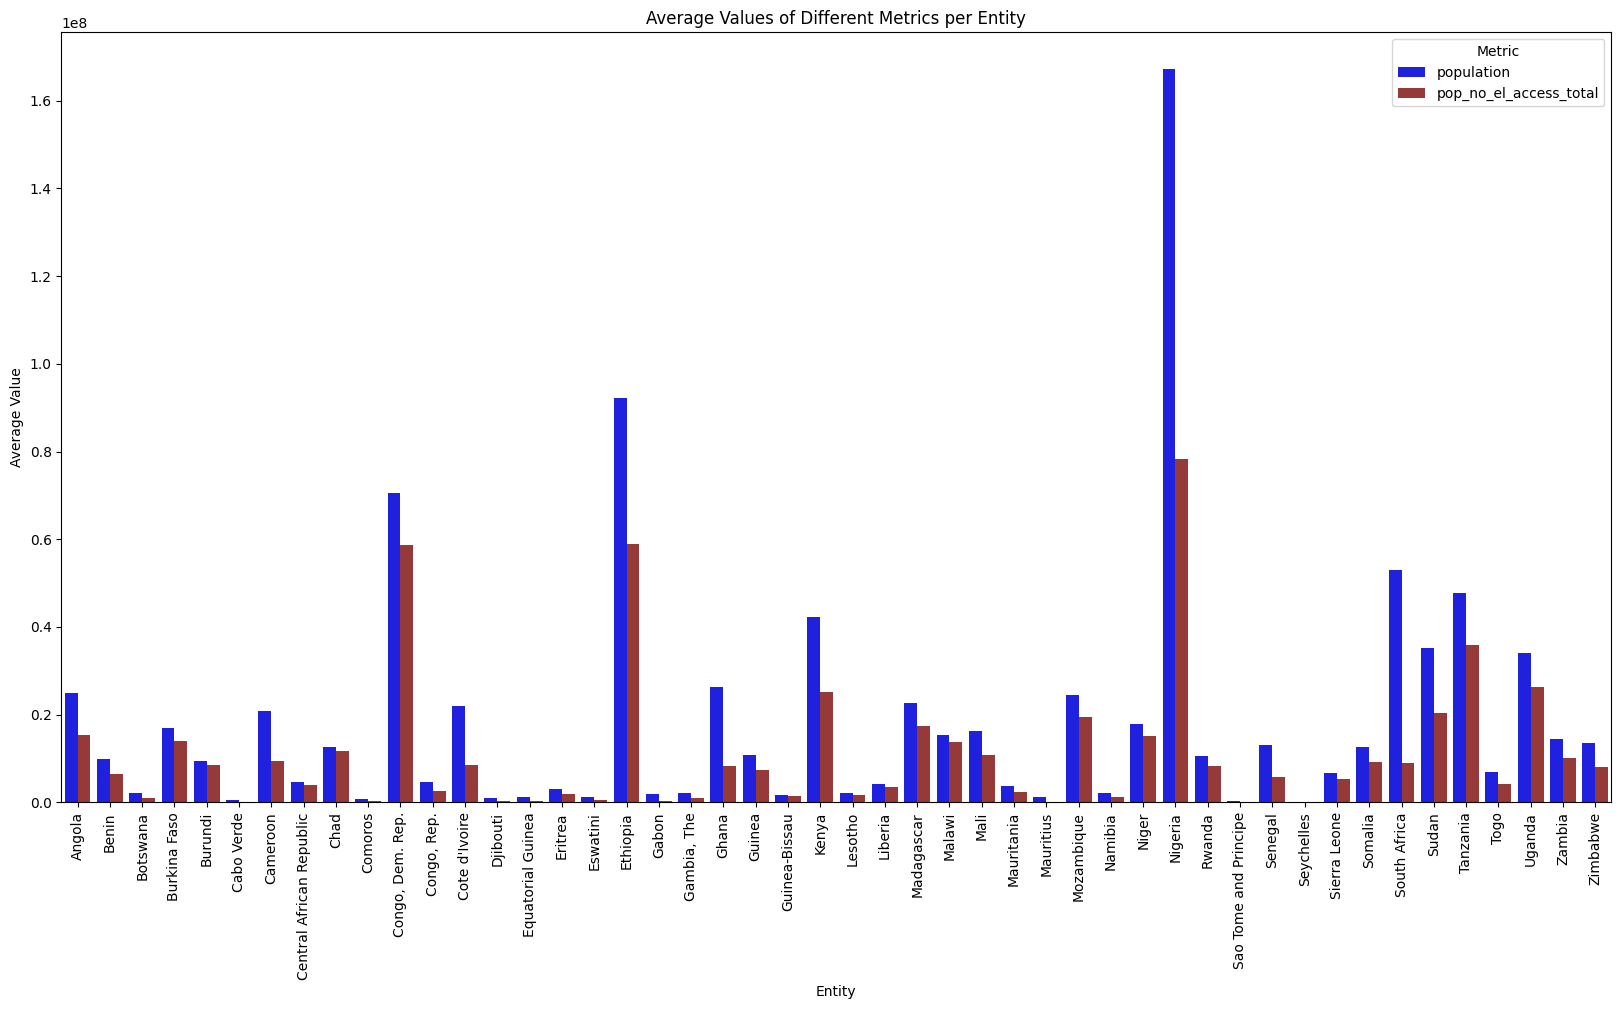

In [42]:
# Melt the DataFrame to long format
avg3_long = avg3.melt(id_vars=['entity'], value_vars=['population', 'pop_no_el_access_total'],
                            var_name='Variable', value_name='Value')
# Plotting
plt.figure(figsize=(20, 10))
sns.barplot(x='entity', y='Value', hue='Variable', data=avg3_long, palette=['blue', 'brown'])
plt.title('Average Values of Different Metrics per Entity')
plt.xlabel('Entity')
plt.ylabel('Average Value')
plt.legend(title='Metric')
plt.xticks(rotation=90)
plt.show()

#6.Final data

Approach 1 is better interpretable, let's stick to it.

In [43]:
#take to data df all cols from dff_pr except gag2 and t_demand2, rename gap1 to gap, t_demand1 to t_demand
data=dff_pr.copy()
data.drop(['gap2', 't_demand2'], axis=1, inplace=True)
data.rename(columns={'gap1': 'gap', 't_demand1': 't_demand'}, inplace=True)
data.columns


Index(['entity', 'year', 'income_group', 'gdp_pc', 'el_access_total',
       'el_access_urban', 'el_access_rural', 'population',
       'pop_no_el_access_total', 'urban_share', 'el_generation', 'el_demand',
       'net_imports', 'el_generation_pc', 'el_demand_pc',
       'final_energy_consumption', 'fin_support', 'el_from_coal',
       'el_from_gas', 'el_from_nuclear', 'el_from_hydro', 'el_from_solar',
       'el_from_oil', 'el_from_wind', 'el_from_bioenergy', 'renewables_other',
       'el_inst_capacity_total', 'income_group_num', 'supply_rate', 't_demand',
       'gap'],
      dtype='object')

In [44]:
data.shape

(1104, 31)

In [45]:
data.to_csv('data.csv', index=False)

In [46]:
#download
from google.colab import files
files.download('data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>